# 第三章 线性神经网络

## 3.1 线性回归

### 3.1.1 线性回归的基本元素

#### 线性模型
* 单样本 $\hat{y} = w_1x_1 + ... + w_dx_d + b$

* 单样本向量表示 $\hat{y} = {\textbf{w}}^\text{T}\textbf{x} + b$

* 多样本 $\hat{\textbf{y}} = \textbf{X}\textbf{w} + b$

#### 损失函数
量化目标的实际值与预测值之间的差距
* 单样本 $l^{(i)}(\textbf{w}, b) = \frac{1}{2}({\hat{y}}^{(i)}-y^{(i)})^2$

* 多样本 $L(\textbf{w},b) = \frac{1}{n}\sum\limits_{i=1}^{n}l^{(i)}(\textbf{w}, b) = \frac{1}{n}\sum\limits_{i=1}^{n}\frac{1}{2}({\textbf{w}}^\text{T}{\textbf{x}}^{(i)}+b-y^{(i)})^2$

训练模型的目标：寻找一组参数$(\textbf{w}^*,b^*)$，这组参数能**最小化在所有训练样本上的总损失**，即：

$$\textbf{w}^*,b^* = \underset{\textbf{w},b}{argmin} L(\textbf{w},b)$$

#### 解析解
线性回归存在解析解：
1. 将偏置$b$合并到参数$\textbf{w}$中，即在包含所有参数的矩阵中附加一列
2. 预测问题变为最小化${||\textbf{y}-\textbf{Xw}||}^2$
3. 损失关于$\textbf{w}$导数为0处为解析解：${\textbf{w}}^*=({\textbf{X}}^\text{T}\textbf{X})^{-1}{\textbf{X}}^\text{T}{\textbf{y}}$

#### 随机梯度下降
并不是所有问题都存在解析解，所以需要随机梯度下降

* 梯度下降 (gradient descent)
    * 不断在损失函数递减的方向上（关于模型参数的导数）更新参数来降低误差
    * 性能问题：每一次更新参数之前都需要遍历整个数据集
* 随机梯度下降 (minibatch stochastic gradient descent)
    * 在每次需要计算更新的时候抽取一小批样本
    * 更新过程的数学表示：
      $$(\textbf{w},b)\leftarrow(\textbf{w},b)-\frac{\eta}{|B|}\sum\limits_{i\in{B}}\partial_{(\textbf{w},b)}l^{(i)}(\textbf{w}, b)$$
        * $\eta$: 学习率
        * $|B|$: 每个小批量中的样本数，即批量大小
        * $\eta$和$|B|$需手动指定，称为**超参数（hyperparameter）**，**调参**是选择超参数的过程
    * 展开：
      $$\textbf{w}\leftarrow\textbf{w}-\frac{\eta}{|B|}\sum\limits_{i\in{B}}\partial_{\textbf{w}}l^{(i)}(\textbf{w}, b)=\textbf{w}-\frac{\eta}{|B|}\sum\limits_{i\in{B}}{\textbf{x}}^{(i)}({\textbf{w}}^\text{T}{\textbf{x}}^{(i)}+b-y^{(i)})$$

      $$b\leftarrow b-\frac{\eta}{|B|}\sum\limits_{i\in{B}}\partial_bl^{(i)}(\textbf{w}, b)=b-\frac{\eta}{|B|}\sum\limits_{i\in{B}}({\textbf{w}}^\text{T}{\textbf{x}}^{(i)}+b-y^{(i)})$$

### 3.1.2 矢量化加速
对计算进行矢量化从而利用**线性代数库**，而不是使用Python for循环

示例：

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

class Timer: #@save
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平时时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

n = 10000
a = torch.ones([n])
b = torch.ones([n])
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.20663 sec'

In [2]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

### 3.1.3 正态分布与平方损失

#### 正态分布 normal distribution
* 也称为高斯分布（Gaussian distribution）
* 随机变量$x$具有均值$\mu$和方差${\sigma}^2$，其正态分布概率密度函数如下：
$$p(x)=\frac{1}{\sqrt{2\pi{\sigma}^2}}\text{exp}(-\frac{1}{2{\sigma}^2}(x-\mu)^2)$$

In [3]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

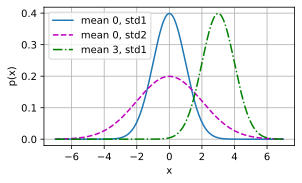

In [4]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x', ylabel='p(x)', figsize=(4.5, 2.5), legend=[f'mean {mu}, std{sigma}' for mu, sigma in params])

#### 为什么均方误差损失函数（均方损失）可以用于线性回归
* 假设观测中包含噪声，噪声服从正态分布，如下：
  $$y=\textbf{w}^\text{T}\textbf{x}+b+\epsilon$$
  其中$\epsilon \sim \mathcal{N}(0,\sigma^2)$
* 通过给定$\textbf{x}$观测到特定$y$的似然（likelihood）
  $$P(y|\textbf{x})=\frac{1}{\sqrt{2\pi\sigma^2}}exp(-\frac{1}{2\sigma^2}(y-\textbf{w}^\text{T}\textbf{x}-b)^2)$$
* 根据极大似然估计法，参数$\textbf{w}$和$b$的最优值是使整个数据集的似然最大的值
  $$P(\textbf{y}|\textbf{X})=\prod_{i=1}^np(y^{(i)}|\textbf{x}^{(i)})$$
* 改为最小化负对数似然
  $$-logP(\textbf{y}|\textbf{X})=\sum_{i=1}^n(\frac{1}{2}\text{log}(2\pi\sigma^2)+\frac{1}{2\sigma^2}(y^{(i)}-\textbf{w}^{\text{T}}\textbf{x}^{(i)}-b)^2)$$
* 第一项不依赖$\textbf{w}$和$b$，第二项除了常数$\frac{1}{\sigma^2}$外，其余部分和均方差是一样的。因此在高斯噪声的假设下，最小化均方差等价于对线性模型的极大似然估计

### *极大似然估计（maximum likelihood estimation, MLE）*
* 利用已知样本结果信息，反推最有可能导致这些样本结果出现的模型参数值
* 既然事情发生了，就让这个出现的结果的可能性最大

### 3.1.4 从线性回归到深度网络
#### 神经网络图
![图3.1.2](./images/3.1.2.png)
* 线性回归是一个单层神经网络（不考虑输入层）
* 对于线性回归，每个输入都与每个输出相连，这种变换称为 **全连接层（fully-connected layer）** 或稠密层（dense layer）

## 3.2 线性回归的从零开始实现

In [5]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 3.2.1 生成数据集

In [6]:
def synthetic_data(w, b, num_examples): #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [7]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features: ', features[0], '\nlabel: ', labels[0])

features:  tensor([0.0909, 0.5587]) 
label:  tensor([2.5028])


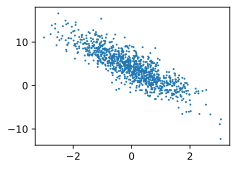

In [8]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 3.2.2 读取数据集

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [10]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.1134,  0.2697],
        [ 0.5092, -1.0706],
        [-0.8774, -2.1639],
        [-2.9018, -0.6705],
        [-1.1922, -2.2030],
        [ 1.6100,  0.1773],
        [-0.7202,  0.8829],
        [ 0.6996,  0.9328],
        [-0.9465, -0.5410],
        [-0.7452,  1.4232]]) 
 tensor([[ 1.0640],
        [ 8.8624],
        [ 9.8085],
        [ 0.6763],
        [ 9.3223],
        [ 6.8160],
        [-0.2480],
        [ 2.4286],
        [ 4.1482],
        [-2.1200]])


### 3.2.3 初始化模型参数

In [11]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 3.2.4 定义模型

In [12]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 3.2.5 定义损失函数

In [13]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6 定义优化算法

In [14]:
def sgd(params, lr, batch_size): #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 3.2.7 训练

In [15]:
lr = 0.03 # 学习率
num_epochs = 3
net = linreg
loss = squared_loss

In [16]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l的形状是(batch_size, 1)，而不是一个标量。l中所有元素被加到一起，并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.040730
epoch 2, loss 0.000157
epoch 3, loss 0.000049


In [17]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([ 0.0004, -0.0007], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0006], grad_fn=<RsubBackward1>)


# 3.3 线性回归的简洁实现
使用深度学习框架

### 3.3.1 生成数据集

In [18]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [19]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 3.3.2 读取数据集
参数is_train表示是否希望数据迭代器对象在每个迭代周期内打乱数据

In [20]:
def load_array(data_arrays, batch_size, is_train=True): #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [21]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [22]:
next(iter(data_iter))

[tensor([[-1.5518,  0.9486],
         [ 1.3826,  0.5705],
         [-0.5019, -0.3787],
         [ 0.2121,  2.0935],
         [ 0.5622, -0.2212],
         [ 0.7045, -0.4826],
         [ 0.0472, -0.3195],
         [-0.1884, -0.5990],
         [-0.4379,  0.2642],
         [-2.0859, -0.6550]]),
 tensor([[-2.1405],
         [ 5.0336],
         [ 4.4953],
         [-2.5123],
         [ 6.0829],
         [ 7.2466],
         [ 5.3846],
         [ 5.8352],
         [ 2.4360],
         [ 2.2473]])]

### 3.3.3 定义模型
* 在PyTorch中，全连接层在Linear类中定义
* nn.Linear()的参数
  * 输入特征形状
  * 输出特征形状

In [23]:
# nn是神经网络的缩写
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

### 3.3.4 初始化模型参数

In [24]:
# net[0]选择网络中的第一个图层
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 3.3.5 定义损失函数
* 计算均方误差使用MSELoss类，也称为平方$L_2$范数。默认返回所有样本损失的平均值

In [25]:
loss = nn.MSELoss()

### 3.3.6 定义优化算法
* PyTorch在optim模块中实现了小批量随机梯度下降算法的许多变种

In [26]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 3.3.7 训练

In [27]:
num_epoch = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000315
epoch 2, loss 0.000096
epoch 3, loss 0.000095


In [28]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([2.2614e-04, 1.0014e-05])
b的估计误差： tensor([6.6280e-05])


# 3.4 softmax回归

## 3.4.1 分类问题
* 问题
    * 图像分类问题。假设每次输入是一个2x2的灰度图像。用一个标量表示每个像素值，每个图像对应四个特征$x_1, x_2, x_3, x_4$。假设每个图像属于类别”猫“，”鸡“和”狗“中的一个
* 如果类别间有一些自然顺序，如{婴儿，儿童，青少年，青年人，中年人，老年人}，那么可以将分类问题转变为回归问题
* 否则，可以使用 **独热编码（one-hot encoding）** 表示分类数据。独热编码是一个向量，它的分量和类别一样多。类别对应的分量设置为1，其他所有分量设置为0
* 对于猫鸡狗问题
  $$y\in\{(1,0,0),(0,1,0),(0,0,1)\}$$

### 3.4.2 网络架构
* 为了估计所有可能类别的概率，我们需要一个有多个输出的模型，**每个类别对应一个输出**
* 为了解决线性模型的分类问题，我们需要和输出一样多的**仿射函数（affine function）**
* 每个输出对应它自己的仿射函数
* 计算式：
  $$o_1=x_1w_{11}+x_2w_{12}+x_3w_{13}+x_4w_{14}+b_1,$$
  $$o_2=x_1w_{21}+x_2w_{22}+x_3w_{23}+x_4w_{24}+b_2,$$
  $$o_3=x_1w_{31}+x_2w_{32}+x_3w_{33}+x_4w_{34}+b_3.$$
  即$\textbf{o}=\textbf{W}\textbf{x}+\textbf{b}$
* 神经网络图：
  
  ![](./images/3.4.1.png)
  
  **softmax回归是一种单层神经网络**

### 3.4.3 全连接层的参数开销
* 理论上$d$个输入和$q$个输出的全连接层，参数开销是$\mathcal{O}(dq)$
* 但是，将$d$个输入转换为$q$个输出的成本可以减少到$\mathcal{O}(\frac{dq}{n})$，其中$n$是超参数，可以灵活指定

### 3.4.4 softmax运算
* 我们希望模型的输出$\hat{y}_j$可以视为属于类$j$的概率，然后选择具有最大输出值的类别$\text{argmax}_jy_j$作为我们的预测
* 输出值$o$不能直接使用，需要**规范化**
  * 没有限制输出数字的总和为1
  * 根据输入不同，输出可能为负值
* 规范化 - 解决上述2个问题
  $$\hat{\textbf{y}}=\text{softmax}(\textbf{o})$$
  其中\
  $$\hat{y_j}=\frac{\text{exp}(o_j)}{\sum_k{\text{exp}(o_k)}}$$
* softmax的性质
  * 不会改变未规范化的预测$\textbf{o}$之间的大小次序，即
  $$\underset{j}{\text{argmax}}\hat{y}_j=\underset{j}{\text{argmax}}o_j$$
  * softmax是一个非线性函数，但输出仍然由输入特征的仿射变换决定。因此，softmax回归是一个**线性模型（linear model）**

### 3.4.5 小批量样本的矢量化
* 读取批量样本$\textbf{X}$，其中特征维度（输入数量）为$d$，批量大小为$n$，输出有$q$个类别
* 那么，$\textbf{X}\in{\mathbb{R}^{n \times d}}$，权重$\textbf{W}\in{\mathbb{R}^{d \times q}}$，偏置$\textbf{b}\in{\mathbb{R}^{1 \times q}}$
* softmax回归的矢量计算表达式为
  $$\textbf{O}=\textbf{XW}+\textbf{b},$$
  $$\hat{\textbf{Y}}=\text{softmax}(\textbf{O}).$$

### 3.4.6 损失函数

#### 对数似然
$$P(\textbf{Y}|\textbf{X})=\prod_{i=1}^nP(\textbf{y}^{(i)}|\textbf{x}^{(i)})$$
根据最大似然估计，最大化$P(\textbf{Y}|\textbf{X})$，相当于最小化负对数似然：
$$-\text{log}P(\textbf{Y}|\textbf{X})=\sum_{i=1}^n-\text{log}P(\textbf{y}^{(i)}|\textbf{x}^{(i)})=\sum_{i=1}^nl(\textbf{y}^{(i)},\hat{\textbf{y}}^{(i)})$$
其中，对于任何标签$\textbf{y}$和模型预测$\hat{\textbf{y}}$，损失函数为：
$$l(\textbf{y},\hat{\textbf{y}})=-\sum_{j=1}^qy_i\text{log}\hat{y}_j$$
上述损失函数通常被称为 **交叉熵损失（cross-entropy loss）**，由于$\textbf{y}$是一个长度为$q$的独热编码向量，所以除了一个项以外的所有项$j$都消失了

#### softmax及其导数
$$l(\textbf{y},\hat{\textbf{y}})=-\sum_{j=1}^qy_i\text{log}\frac{\text{exp}(o_j)}{\sum_{k=1}^q{\text{exp}(o_k)}}=\sum_{j=1}^qy_j\text{log}\sum_{k=1}^q\text{exp}(o_k)-\sum_{j=1}^qy_jo_j=\text{log}\sum_{k=1}^q\text{exp}(o_k)-\sum_{j=1}^qy_jo_j$$
考虑相对于任何未规范化的预测$o_j$的导数，得到：
$$\partial_{o_j}l(\textbf{y},\hat{\textbf{y}})=\frac{\text{exp}(o_j)}{\sum_{k=1}^q{\text{exp}(o_k)}}-y_j=\text{softmax}(\textbf{o})_j-y_j$$
导数是softmax模型分配的概率与实际发生的情况（由独热标签向量表示）之间的差异

### 3.4.7 信息论基础

### 3.4.8 模型预测和评估
* 通常使用预测概率最高的类别作为输出类别。如果预测与实际类别（标签）一致，则预测是正确的
* 使用精度（accuracy）来评估模型的性能，精度等于正确预测数与预测总数的比率

## 3.5 图像分类数据集
* MNIST数据集，图像分类中广泛使用的数据集之一，但作为基准数据集过于简单
* Fashion-MNIST数据集，类似MNIST，更复杂
  * 由10个类别的图像组成，每个类别由训练数据集（train dataset）中的6000张图像和测试数据集（test dataset）中的1000张图像组成。因此，训练集和测试集分别包含60000和10000张图像
  * 每个图像的高度和宽度均为28像素。数据集由灰度图像组成，其通道数为1
  * 10个类别为：t-shirt, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag和ankle boot
  * 测试数据集不用于训练，只能用于模型评估

In [29]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

### 3.5.1 读取数据集

In [30]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，并除以255使得所有像素数值均在0~1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

In [31]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [32]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [33]:
# 用于在数字标签索引和其文本名称之间进行转换
def get_fashion_mnist_labels(labels): #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels=['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [34]:
# 可视化样本
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

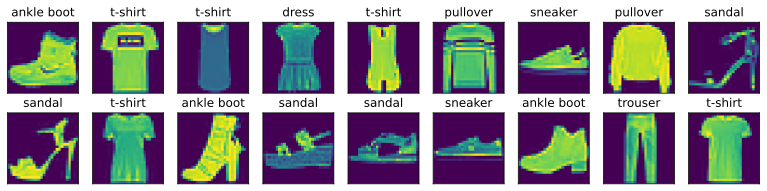

In [35]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

![fashion-mnist-3.5.1.png](./images/fashion-mnist-3.5.1.png)

### 3.5.2 读取小批量

In [36]:
batch_size = 256

def get_dataloader_workers(): #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

In [37]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'6.12 sec'

### 3.5.3 整合所有组件

In [38]:
# 用于获取和读取Fashion-MNIST数据集，返回训练集和验证集的数据迭代器，接受一个可选参数resize，用来将图像大小调整为另一种形式
def load_data_fashion_mnist(batch_size, resize=None): #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())
, data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=get_dataloader_workers()))

In [39]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## 3.6 softmax回归的从零开始实现

In [40]:
import torch
from IPython import display
from d2l import torch as d2l

In [41]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 3.6.1 初始化模型参数

In [42]:
num_inputs = 784 # 28 x 28
num_outputs = 10 # 10个类别

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

### 3.6.2 定义softmax操作

In [43]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0), X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([5., 7., 9.]),
 tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [44]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 广播机制

In [45]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1520, 0.0747, 0.0970, 0.4924, 0.1839],
         [0.0364, 0.1163, 0.3582, 0.3870, 0.1021]]),
 tensor([1.0000, 1.0000]))

### 3.6.3 定义模型

In [46]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

### 3.6.4 定义损失函数
交叉熵损失的公式：
$$l(\textbf{y},\hat{\textbf{y}})=-\sum_{j=1}^qy_i\text{log}\hat{y}_j$$
只有对应真实类别的$y_i$才是非0的

In [47]:
y = torch.tensor([0, 2]) # 第一个样本是类别0，第二个样本是类别2, 此处不是独热编码
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [48]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

In [49]:
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 3.6.5 分类精度

In [50]:
def accuracy(y_hat, y): #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y # [False, True]
    return float(cmp.type(y.dtype).sum()) # [False, True] -> [0, 1]再求和

In [51]:
accuracy(y_hat, y) / len(y) # 第一个样本预测错误

0.5

In [52]:
def evaluate_accuracy(net, data_iter): #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [53]:
class Accumulator: #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [54]:
evaluate_accuracy(net, test_iter) # 使用初始化参数

0.0573

### 3.6.6 训练

In [55]:
def train_epoch_ch3(net, train_iter, loss, updater): #@save
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [56]:
class Animator: #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, xscale='linear', yscale='linear', fmts=('-', 'm--', 'g-', 'r:'), nrows=1, ncols=1, figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [57]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save
    """训练模型"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [58]:
lr = 0.1 # 学习率

# 使用小批量随机梯度下降来优化模型的损失函数
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

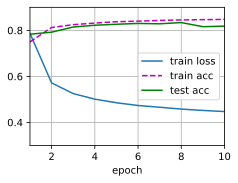

In [59]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 3.6.7 预测

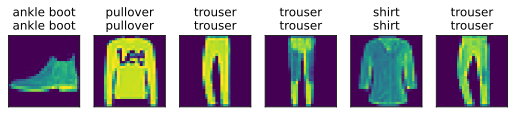

In [60]:
def predict_ch3(net, test_iter, n=6): #@save
    """预测标签"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

![fashion-mnist-3.6.7.png](./images/fashion-mnist-3.6.7.png)

## 3.7 softmax回归的简洁实现

In [61]:
import torch
from torch import nn
from d2l import torch as d2l

In [62]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 3.7.1 初始化模型参数
softmax回归的输出层是一个全连接层。因此，为了实现模型，只需在Sequential中添加一个带有10个输出的全连接层

In [63]:
# PyTorch不会隐式地调整输入的形状。因此，我们在线性层前定义了展平层（flatten）来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

### 3.7.2 重新审视softmax的实现

$\hat{y}_j=\frac{\text{exp}(o_j)}{\sum_k\text{exp}(o_k)}$，$o_k$过大可能上溢。可以从所有$o_k$中减去$\text{max}(o_k)$防止上溢，但是又可能出现较大的负值使得$\text{exp}(o_j-\text{max}(o_k))$接近0，即下溢。使用下式避免计算$\text{exp}(o_j-\text{max}(o_k))$：
$$\text{log}(\hat{y}_j)=\text{log}(\frac{\text{exp}(o_j-\text{max}(o_k))}{\sum_k\text{exp}(o_k-\text{max}(o_k))})=\text{log}(\text{exp}(o_j-\text{max}(o_k)))-\text{log}(\sum_k\text{exp}(o_k-\text{max}(o_k)))=o_j-\text{max}(o_k)-\text{log}(\sum_k\text{exp}(o_k-\text{max}(o_k)))$$

In [64]:
loss = nn.CrossEntropyLoss(reduction='none')

### 3.7.3 优化算法

In [65]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

### 3.7.4 训练

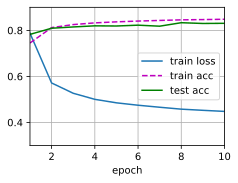

In [66]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)